<a href="https://colab.research.google.com/github/tnotstar/machine-learning-zoomcamp-2025-projects-capstone1/blob/main/submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Zoomcamp (Cohort 2025) #

## Capstone Project 1: A Genetic Variants Conflicting Classification Predictor Service ##



### Description of the problem

This project focuses on the classification of genetic variants using data from [ClinVar], a freely accessible, public archive hosted by the **National Center for Biotechnology Information (NCBI)**. This work has been inspired by previous research in the field by [Alexandra Veres].

#### What is ClinVar?

[ClinVar]: https://www.ncbi.nlm.nih.gov/clinvar/intro

According to the _NCBI_, **ClinVar** is a centralized repository that aggregates reports of the relationships among human variations and phenotypes, with supporting evidence. It facilitates access to and communication about the relationships asserted between human variation and observed health status. Interpretations of the clinical significance of variants are submitted by clinical testing laboratories, research laboratories, and expert panels worldwide.

### Problem Statement

The dataset for this project originates from the work of [Alexandra Veres], based on a curated version of ClinVar data.

[Alexandra Veres]: https://www.kaggle.com/code/alexandraveres/supervised-learning-classification

In the clinical field, genetic variants are typically classified on a categorical spectrum: **Benign**, **Likely Benign**, **Uncertain Significance (VUS)**, **Likely Pathogenic**, and **Pathogenic**. However, different laboratories often submit conflicting interpretations for the same variant. These conflicts (e.g., one lab classifying a variant as "Benign" while another labels it "VUS") create significant uncertainty for clinicians and researchers attempting to diagnose or treat patients.

### Objective

The goal of this project is to build a binary classification model to predict whether a **ClinVar** variant will have conflicting classifications (represented by the `CLASS` column).

* 0: Consistent classifications.
* 1: Conflicting classifications.

By applying modern machine learning techniques and best practices —as taught in the #MLZoomcamp—, this project aims to automate the identification of these "high-conflict" variants, providing a valuable tool for genomic data quality control and clinical decision support.

### Data Preparation and Data Cleaning

#### Dataset Description

The dataset used in this project is a curated version of the _ClinVar Conflicting Genetic Variants_ library. It contains information on genetic variants that have been interpreted by multiple laboratories, specifically focusing on those with "conflicting" classifications.

#### Dataset Characteristics

Based on the original study by Alexandra Veres, this dataset is characterized by:

* Real-world Genomic Data: Extracted from the NCBI ClinVar database.

* Feature Diversity: 65 initial features covering genomic coordinates, molecular consequences, and clinical metadata.

* Target Variable: A binary label (CLASS) where 1 indicates a conflict in clinical interpretation and 0 indicates consistency.

* Scientific Relevance: Ideal for testing classification models in a high-stakes healthcare context where data imbalance and feature selection are critical.

#### Dataset Retrieval and Loading

The data can be retrieved directly from [Kaggle]. You can use the following URL to out local copy of the data set, for reference or automated downloading:

[Kaggle]: https://www.kaggle.com/code/alexandraveres/supervised-learning-classification

> Local URL: https://github.com/tnotstar/machine-learning-zoomcamp-2025-projects-capstone1/raw/refs/heads/main/dataset/clinvar_conflicting.csv.zip

Following code makes use of the `wget` command line utility to retrieve data from its source.

In [1]:
!wget -N 'https://github.com/tnotstar/machine-learning-zoomcamp-2025-projects-capstone1/raw/refs/heads/main/dataset/clinvar_conflicting.csv.zip'

--2026-01-07 18:13:48--  https://github.com/tnotstar/machine-learning-zoomcamp-2025-projects-capstone1/raw/refs/heads/main/dataset/clinvar_conflicting.csv.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tnotstar/machine-learning-zoomcamp-2025-projects-capstone1/refs/heads/main/dataset/clinvar_conflicting.csv.zip [following]
--2026-01-07 18:13:49--  https://raw.githubusercontent.com/tnotstar/machine-learning-zoomcamp-2025-projects-capstone1/refs/heads/main/dataset/clinvar_conflicting.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3761083 (3.6M) [application/zip]
Saving to: ‘clinvar_c

#### Creating the main data frame

To create our main working data frame we need to issue following Python code:

In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('clinvar_conflicting.csv.zip', dtype=str)
display(df)

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2
1,1,1470752,G,A,0,0,0,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31,6.517838,-3
2,1,1737942,A,G,0,0.00001,0,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.1,6.061752,-1
3,1,2160305,G,A,0,0,0,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.5,3.114491,NaN
4,1,2160305,G,T,0,0,0,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.7,4.766224,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65183,X,154158201,T,G,0.0801,0.13923,0.1605,"MedGen:C0019069,OMIM:306700,SNOMED_CT:28293008...",NaN,Hereditary_factor_VIII_deficiency_disease|not_...,...,NaN,NaN,NaN,NaN,NaN,NaN,0.00158,0.105,-0.630908,NaN
65184,X,154159118,C,T,0.0020,0.00060,0.0013,MedGen:CN169374|MedGen:CN239152,NaN,"not_specified|Hemophilia_A,_FVIII_Deficiency",...,tolerated,benign,NaN,NaN,NaN,NaN,0.00158,0.002,-1.731470,3
65185,X,154194886,C,T,0.0125,0.00370,0.0111,MedGen:CN169374|MedGen:CN239152,NaN,"not_specified|Hemophilia_A,_FVIII_Deficiency",...,NaN,NaN,NaN,NaN,NaN,NaN,0.00158,12.85,1.412434,NaN
65186,X,154490187,T,C,0.0003,0.00034,0,"MedGen:C3501611,Orphanet:ORPHA777|MedGen:CN169374",NaN,Non-syndromic_X-linked_intellectual_disability...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.130,-0.592415,NaN


#### Data Dictionary of Some Relevant Features (e.g. Reported By Alexandra Veres)

| Feature | Description | Type |
| :--- | :--- | :--- |
| **CHROM** | The chromosome where the genetic variant is located. | Categorical |
| **POS** | The exact position of the variant on the chromosome. | Numerical |
| **REF** | The reference allele (the "normal" nucleotide). | Categorical |
| **ALT** | The alternative allele (the "mutated" nucleotide). | Categorical |
| **AF_ESP** | Allele frequency in the NHLBI Exome Sequencing Project. | Numerical |
| **CLNSIG** | The reported clinical significance (e.g., Benign, Pathogenic). | Categorical |
| **CLNVC** | The type of variant (e.g., single nucleotide variant, deletion). | Categorical |
| **MC** | Molecular Consequence (e.g., missense variant, frameshift). | Categorical |
| **IMPACT** | Predicted impact of the variant (HIGH, MODERATE, LOW). | Categorical |
| **CLASS** | **Target Variable:** 1 if conflicting, 0 if consistent. | Binary |

#### Verifying data dimensions and identifiers

The loaded dataset contains an amount of **$65,188$ rows and $46$ columns per row**. The names of columns could be used as identifiers without any previous transformation, but we decided to make names lowercase:

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['chrom', 'pos', 'ref', 'alt', 'af_esp', 'af_exac', 'af_tgp', 'clndisdb',
       'clndisdbincl', 'clndn', 'clndnincl', 'clnhgvs', 'clnsigincl', 'clnvc',
       'clnvi', 'mc', 'origin', 'ssr', 'class', 'allele', 'consequence',
       'impact', 'symbol', 'feature_type', 'feature', 'biotype', 'exon',
       'intron', 'cdna_position', 'cds_position', 'protein_position',
       'amino_acids', 'codons', 'distance', 'strand', 'bam_edit', 'sift',
       'polyphen', 'motif_name', 'motif_pos', 'high_inf_pos',
       'motif_score_change', 'loftool', 'cadd_phred', 'cadd_raw', 'blosum62'],
      dtype='object')

#### Target variable

As indicated in the dataset's description, the target variable is the _**CLASS**_, renamed here to **`class`**.

In [4]:
target_variable = "class"
print(f"Target variable: '{target_variable}'")

# Convert 'class' column to integer type
df[target_variable] = df[target_variable].astype(int)

Target variable: 'class'


#### Verifying missing values

To check for missing values we can count data at each column:

In [5]:
df.isnull().sum().sort_values(axis=0, ascending=False)

,0
motif_pos,65186
motif_name,65186
motif_score_change,65186
high_inf_pos,65186
distance,65080
ssr,65058
clnsigincl,65021
clndisdbincl,65021
clndnincl,65021
intron,56385


where `count` is different from the number of rows in the data set:

In [6]:
df.shape

(65188, 46)

Now, we also need to identify categorical columns with high cardinality values:

In [7]:
category_candidates = df.select_dtypes(include=['object', 'category']).columns
df[category_candidates].nunique().sort_values(axis=0, ascending=False)

,0
clnhgvs,65188
cadd_raw,63803
pos,63115
clnvi,27654
cdna_position,13970
cds_position,13663
cadd_phred,9324
clndn,9260
clndisdb,9234
protein_position,7339


Given the significant number of missing values and high cardinalities in several columns, a straightforward strategy for handling NaNs would be:

##### Drop highly sparse columns

We will identify and remove columns that have more than 20% missing values, as these are unlikely to contribute meaningfully to the model. This criterion is consistent with the original work by Alexandra Verses.

Also, we will drop columns which unique values a above the 5% of the number of rows of the data set.

However, an exception will be made for the 'intron' and 'exon' columns. These features will be preserved regardless of their missing value count, as they provide critical information for variant classification whenever their values are present.

Finally, we will remove identifier columns from our dataset, as they are not meaningful for prediction.



In [8]:
# Calculate NaN percentages
nan_percentages = 100 * df.isnull().sum() / len(df)

# Identify columns to drop due to missing values (>20%)
columns_to_drop = nan_percentages[nan_percentages > 20].index.tolist()

# Exception: Preserve "intron" and "exon" for later feature engineering
for col in ["intron", "exon"]:
    if col in columns_to_drop:
        columns_to_drop.remove(col)

# We include your specific identifier column list as well
columns_to_drop = list(set(columns_to_drop + ["clndisdb", "clndn", "clnhgvs", "clnvc"]))

# Final Drop
print(f"List of columns to drop: {columns_to_drop}")
print(f"Total columns to drop: {len(columns_to_drop)}")
df = df.drop(columns=columns_to_drop)

List of columns to drop: ['clndn', 'distance', 'sift', 'clnvc', 'clndisdbincl', 'clnsigincl', 'motif_pos', 'ssr', 'clnvi', 'motif_name', 'bam_edit', 'clndnincl', 'high_inf_pos', 'clnhgvs', 'motif_score_change', 'clndisdb', 'polyphen', 'blosum62']
Total columns to drop: 18


#### Numerical versus Categorical features

As data has been loaded with `dtype=str` parameter (see cells above), we need to coerce columns to its convinient data type before we can use it.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   chrom             65188 non-null  object
 1   pos               65188 non-null  object
 2   ref               65188 non-null  object
 3   alt               65188 non-null  object
 4   af_esp            65188 non-null  object
 5   af_exac           65188 non-null  object
 6   af_tgp            65188 non-null  object
 7   mc                64342 non-null  object
 8   origin            65188 non-null  object
 9   class             65188 non-null  int64 
 10  allele            65188 non-null  object
 11  consequence       65188 non-null  object
 12  impact            65188 non-null  object
 13  symbol            65172 non-null  object
 14  feature_type      65174 non-null  object
 15  feature           65174 non-null  object
 16  biotype           65172 non-null  object
 17  exon        

##### Identify Feature Types

This step evaluates the DataFrame's column types to ensure our feature lists are accurate and reflect the current state of the data. This is crucial for the next imputation step.

In [10]:
numerical_columns_to_convert = []

for col in df.columns:
  # we explicitly exclude `strand` from numerical columns
  if col == "strand":
    continue

  # first we count missing values before coertion testing
  valid_before = df[col].count()

  # if a column has no values, we assume it's categorical
  if valid_before == 0:
    continue

  # next, we try converting to numeric
  converted = pd.to_numeric(df[col], errors='coerce')

  # and count missing values
  valid_after = converted.count()

  # if we have no more missing values then the column is numeric
  if valid_before == valid_after:
      numerical_columns_to_convert.append(col)

numerical_columns_to_convert = list(set(numerical_columns_to_convert + ["cdna_position", "cds_position", "protein_position"]))
print(f"Numerical columns to convert: {numerical_columns_to_convert}")

Numerical columns to convert: ['af_exac', 'af_esp', 'origin', 'loftool', 'pos', 'cadd_raw', 'cdna_position', 'cds_position', 'protein_position', 'class', 'cadd_phred', 'af_tgp']


Then we convert columns and create two feature lists for numerical and categorical variables:

In [11]:
# Convert these columns to numeric, coercing errors to NaN
for col in numerical_columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Identify numerical and categorical features after type conversion
numerical_features = df.select_dtypes(include=np.number).columns
if target_variable in numerical_features:
    numerical_features = numerical_features.drop(target_variable)
print(f"Numerical features: {sorted(numerical_features.tolist())}")

categorical_features = df.select_dtypes(include=object).columns # Use object for string/mixed types

# Also consider `chrom` as categorical, as it's typically an identifier
if "chrom" not in categorical_features:
  categorical_features = categorical_features.tolist() + ['chrom']

# Convert remaining object columns to category type
for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype("category")

categorical_features = df.select_dtypes(include='category').columns
if target_variable in categorical_features:
    categorical_features = categorical_features.drop(target_variable)
print(f"Categorical features: {sorted(categorical_features.tolist())}")

Numerical features: ['af_esp', 'af_exac', 'af_tgp', 'cadd_phred', 'cadd_raw', 'cdna_position', 'cds_position', 'loftool', 'origin', 'pos', 'protein_position']
Categorical features: ['allele', 'alt', 'amino_acids', 'biotype', 'chrom', 'codons', 'consequence', 'exon', 'feature', 'feature_type', 'impact', 'intron', 'mc', 'ref', 'strand', 'symbol']


Now we create a merge of columns `exom` and `intron` by creating the location type column and a common location value column:

In [12]:
# Create 'location_type' using np.select (cleaner and faster than multiple if/else)
conditions = [
    df["exon"].notna(),
    df["intron"].notna()
]
choices = ["exon", "intron"]

df["location_type"] = np.select(conditions, choices, default="unknown")
df["location_type"] = df["location_type"].astype("category")

# Create 'location_value'
# We take the value from exon if present, otherwise from intron, else NaN
df["location_value"] = np.where(
    df["exon"].notna(),
    df["exon"].astype(str),
    np.where(df["intron"].notna(), df["intron"].astype(str), "unknown")
)
df["location_value"] = df["location_value"].astype("category")

# Clean up the original columns
df = df.drop(columns=['intron', 'exon'])
categorical_features = list(set(categorical_features) - set(["intron", "exon"]))

Then we data set currently has the following structure:

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   chrom             65188 non-null  category
 1   pos               65188 non-null  int64   
 2   ref               65188 non-null  category
 3   alt               65188 non-null  category
 4   af_esp            65188 non-null  float64 
 5   af_exac           65188 non-null  float64 
 6   af_tgp            65188 non-null  float64 
 7   mc                64342 non-null  category
 8   origin            65188 non-null  int64   
 9   class             65188 non-null  int64   
 10  allele            65188 non-null  category
 11  consequence       65188 non-null  category
 12  impact            65188 non-null  category
 13  symbol            65172 non-null  category
 14  feature_type      65174 non-null  category
 15  feature           65174 non-null  category
 16  biotype           6517

Then, we identify high cardinality categorical columns (>5% unique values) to drop them all:

In [14]:
# We calculate the dynamic threshold here
cardinality_threshold = 0.02 * len(df)
print(f"Cardinality threshold (2% of rows): {cardinality_threshold:.0f}")

# We only check columns that are not already in the drop list
high_cardinality_cols = [
  col for col in categorical_features if col not in columns_to_drop and df[col].nunique() > cardinality_threshold
]

# Clean up the original columns
print(f"High cardinality columns: {high_cardinality_cols}")
df = df.drop(columns=high_cardinality_cols)
categorical_features = list(set(categorical_features) - set(high_cardinality_cols))


Cardinality threshold (2% of rows): 1304
High cardinality columns: ['codons', 'symbol', 'feature']


##### Impute Remaining NaNs

1. **Numerical Features**

   For any numerical columns that still contained NaNs (those not dropped in the first step), we filled these missing values with the median of that specific column. The median is chosen over the mean because it is less sensitive to outliers, providing a more robust imputation.

In [15]:
# Iterating through the numerical features list to fill missing values
for col in numerical_features:
    # 1. Calculate the median (Pandas automatically ignores NaNs)
    median_value = df[col].median()

    # 2. Fill the missing values in the column
    df[col] = df[col].fillna(median_value)

# Verification: check if any nulls remain in numerical columns
print(df[numerical_features].isnull().sum())

pos                 0
af_esp              0
af_exac             0
af_tgp              0
origin              0
cdna_position       0
cds_position        0
protein_position    0
loftool             0
cadd_phred          0
cadd_raw            0
dtype: int64


2. **Categorical Features**

   For categorical columns with NaNs, we filled them with the mode (the most frequently occurring category) of that column. This ensures that all categorical entries are valid categories and helps maintain the distribution of the existing data.

In [16]:
# Iterating through categorical features to fill missing values with the Mode
for col in categorical_features:
    # 1. Calculate the mode
    # (mode() returns a Series, so we take the first element [0])
    feature_mode = df[col].mode()[0]

    # 2. Fill the missing values
    df[col] = df[col].fillna(feature_mode)

# Verification: check that no nulls remain
print(df[categorical_features].isnull().sum())

alt             0
ref             0
biotype         0
consequence     0
impact          0
amino_acids     0
feature_type    0
mc              0
allele          0
chrom           0
strand          0
dtype: int64


Finally, we store a local copy of our prepared data set:

In [17]:
df.to_parquet("prepared_clinvar_conflicting.parquet", index=False)

### Exploratory Data Analysis

Following libraries will be used across this work:

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score

import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

We begin our exploratory data analysis (EDA) by examining the distribution of our target variable, `class`. This is a crucial first step in any classification problem, especially in fraud detection, where datasets are often unbalanced.

Read data from saved local copy of prepared data set:

In [19]:
df = pd.read_parquet("prepared_clinvar_conflicting.parquet")
display(df)
print()

target_variable = "class"
print(f"Target variable: '{target_variable}'")

# Identify numerical features after type conversion
numerical_features = df.select_dtypes(include=np.number).columns
if target_variable in numerical_features:
    numerical_features = numerical_features.drop(target_variable)
print(f"Numerical features: {sorted(numerical_features.tolist())}")


# Identify categorical features after type conversion
categorical_features = df.select_dtypes(include='category').columns
if target_variable in categorical_features:
    categorical_features = categorical_features.drop(target_variable)
print(f"Categorical features: {sorted(categorical_features.tolist())}")

,chrom,pos,ref,alt,af_esp,af_exac,af_tgp,mc,origin,class,...,cdna_position,cds_position,protein_position,amino_acids,strand,loftool,cadd_phred,cadd_raw,location_type,location_value
0,1,1168180,G,C,0.0771,0.10020,0.1066,SO:0001583|missense_variant,1,0,...,552.0,522.0,174.0,E/D,1,0.15700,1.053,-0.208682,exon,1/1
1,1,1470752,G,A,0.0000,0.00000,0.0000,SO:0001583|missense_variant,1,0,...,523.0,509.0,170.0,P/L,-1,0.15700,31.000,6.517838,exon,4/4
2,1,1737942,A,G,0.0000,0.00001,0.0000,"SO:0001583|missense_variant,SO:0001623|5_prime...",35,1,...,632.0,239.0,80.0,I/T,-1,0.15700,28.100,6.061752,exon,6/12
3,1,2160305,G,A,0.0000,0.00000,0.0000,SO:0001583|missense_variant,33,0,...,132.0,100.0,34.0,G/S,1,0.15700,22.500,3.114491,exon,1/7
4,1,2160305,G,T,0.0000,0.00000,0.0000,SO:0001583|missense_variant,33,0,...,132.0,100.0,34.0,G/C,1,0.15700,24.700,4.766224,exon,1/7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65183,X,154158201,T,G,0.0801,0.13923,0.1605,SO:0001819|synonymous_variant,1,0,...,4035.0,3864.0,1288.0,S,-1,0.00158,0.105,-0.630908,exon,14/26
65184,X,154159118,C,T,0.0020,0.00060,0.0013,SO:0001583|missense_variant,1,1,...,3118.0,2947.0,983.0,V/I,-1,0.00158,0.002,-1.731470,exon,14/26
65185,X,154194886,C,T,0.0125,0.00370,0.0111,SO:0001819|synonymous_variant,1,0,...,1257.0,1086.0,362.0,A,-1,0.00158,12.850,1.412434,exon,8/26
65186,X,154490187,T,C,0.0003,0.00034,0.0000,SO:0001819|synonymous_variant,1,0,...,822.0,543.0,181.0,T,-1,0.15700,0.130,-0.592415,exon,2/2



Target variable: 'class'
Numerical features: ['af_esp', 'af_exac', 'af_tgp', 'cadd_phred', 'cadd_raw', 'cdna_position', 'cds_position', 'loftool', 'origin', 'pos', 'protein_position']
Categorical features: ['allele', 'alt', 'amino_acids', 'biotype', 'chrom', 'consequence', 'feature_type', 'impact', 'location_type', 'location_value', 'mc', 'ref', 'strand']


As original work, we apply feature scaling:

In [20]:
mm = MinMaxScaler()
for column in [numerical_features]:
    df[column] = mm.fit_transform(df[column])

Custom display names are overwritten in the following code:

In [21]:
feature_display_names = dict(zip(df.columns, df.columns))
feature_display_names["class"] = "Class (0: Consistent, 1: Conflicting)"

Target variable distribution and balancing is showed by:

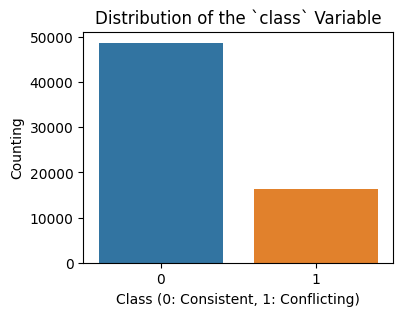


Percentage of Consistent Reporting: 74.79%
Percentage of Conflicting Reporting: 25.21%
Counts of Consistent Reporting: 48754
Counts of Conflicting Reporting: 16434


In [22]:
plt.figure(figsize=(4, 3))
sns.color_palette("hls", 8)
sns.countplot(x=target_variable, data=df, hue=target_variable, legend=False)
plt.title(f"Distribution of the `{target_variable}` Variable")
plt.xlabel(feature_display_names[target_variable])
plt.ylabel("Counting")
plt.show()
print()

target_percentages = 100 * df[target_variable].value_counts(normalize=True)
print(f"Percentage of Consistent Reporting: {target_percentages.iloc[0]:.2f}%")
print(f"Percentage of Conflicting Reporting: {target_percentages.iloc[1]:.2f}%")

target_counts = df[target_variable].value_counts(normalize=False)
print(f"Counts of Consistent Reporting: {target_counts.iloc[0]:d}")
print(f"Counts of Conflicting Reporting: {target_counts.iloc[1]:d}")


Since datasets can be designed with or without target variable balancing, the graph above is useful for determining whether an imbalance exists. In this case, the representation of conflicting reporting in our dataset is not so quite balanced.

The observation that approximately 25.21% of the variants have conflicting classifications (`class == 1`) is noteworthy for several reasons:

1. **High Proportion:** In a real-world clinical context, 25% is a significant proportion of variants to have conflicting interpretations. This highlights the practical importance and clinical relevance of building a model to identify such variants, as it addresses a genuine challenge in genetic diagnostics.

2. **Favorable for Classification Modeling:** From a machine learning perspective, this distribution is quite favorable. Datasets with extreme class imbalance (e.g., 1-5% positive cases) often pose significant challenges for model training, requiring specialized techniques like oversampling, undersampling, or custom loss functions. With 25.21% of the target class, we have a sufficiently large number of positive samples for the model to learn meaningful patterns and generalize effectively. This allows for more robust training and evaluation of classification models using standard approaches, leading to more reliable performance metrics.


#### Numerical Feature Distributions

In this subsection we examine the distribution of key numerical features using histograms and box plots to identify their ranges, skewness, and potential outliers.

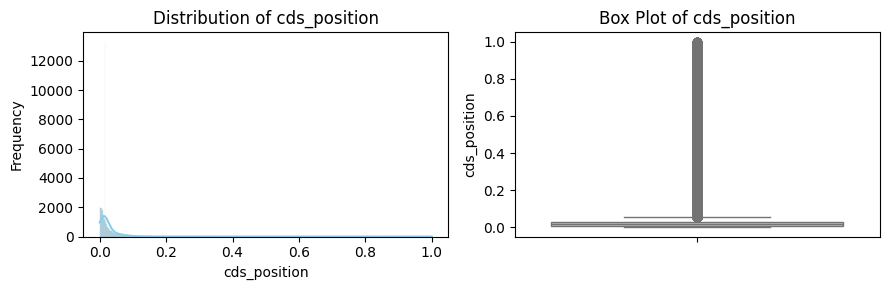

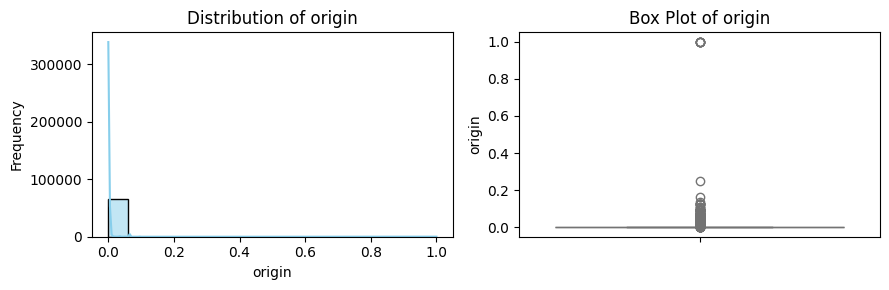

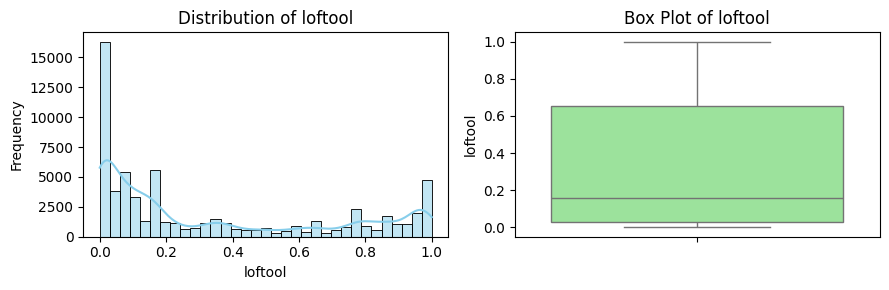

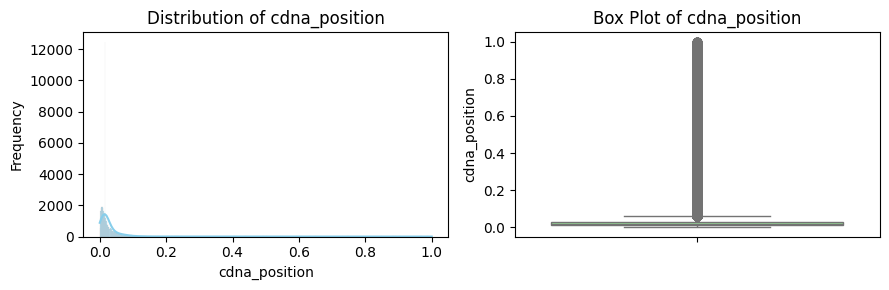

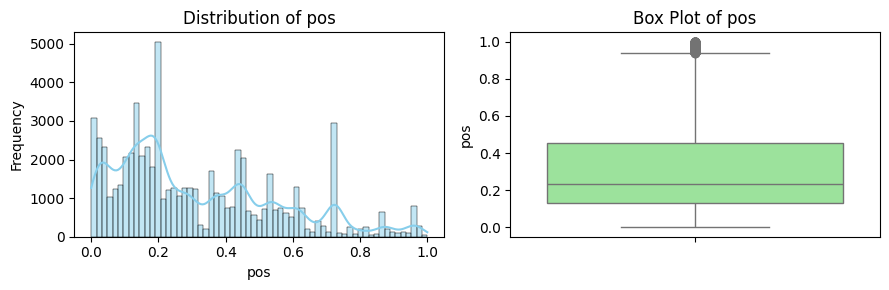

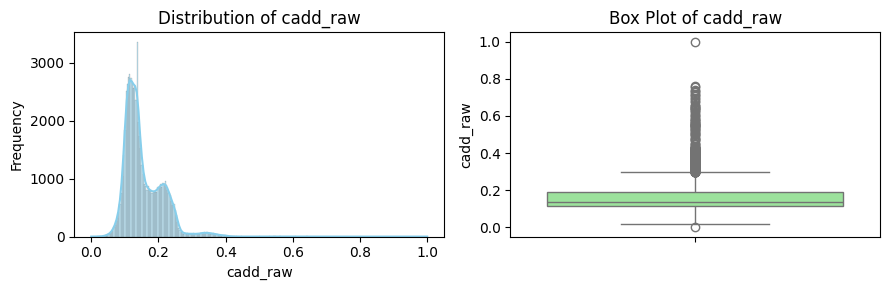

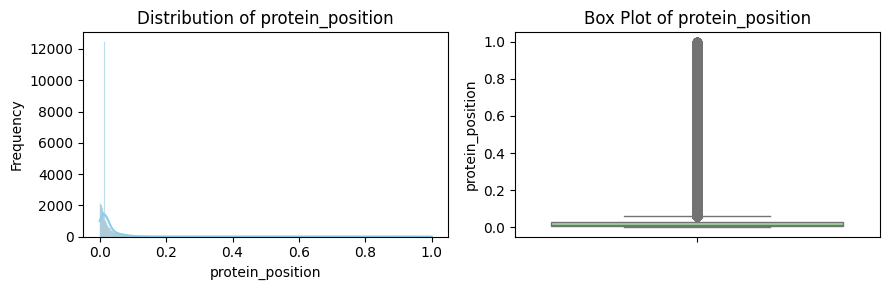

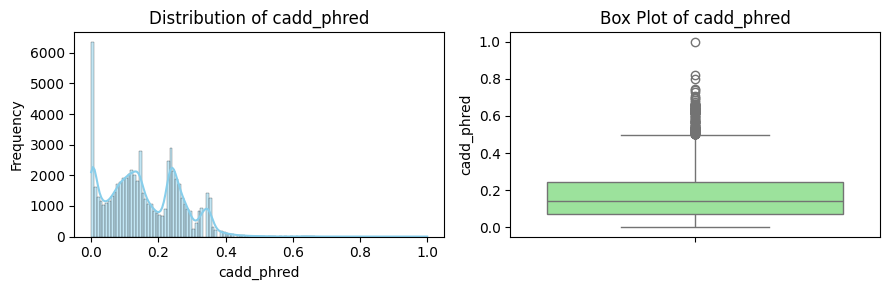

In [23]:
sns.color_palette("hls", 8)
selected_features = set(numerical_features) - set(["af_esp", "af_exac", "af_tgp"])
for feature in selected_features:
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, color="skyblue")
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature_display_names[feature])
    plt.ylabel("Frequency")
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[feature], color="lightgreen")
    plt.title(f"Box Plot of {feature}")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

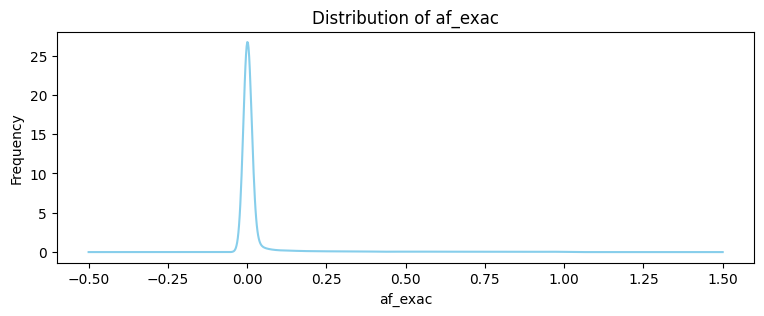

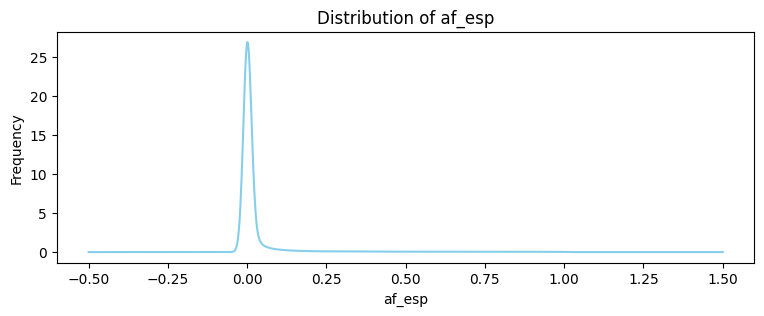

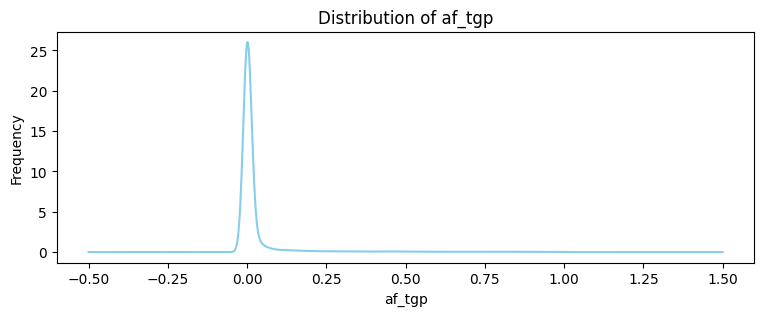

In [24]:
sns.color_palette("hls", 8)
selected_features = set(["af_esp", "af_exac", "af_tgp"])
for feature in selected_features:
  plt.figure(figsize=(9, 3))
  df[feature].plot(kind="kde", color="skyblue")
  plt.title(f"Distribution of {feature}")
  plt.xlabel(feature_display_names[feature])
  plt.ylabel("Frequency")
  plt.show()

### Categorical Feature Distributions

Here we show the distribution of categorical features using  bar plots. This will help in understanding the frequency and proportion of each category within these features.

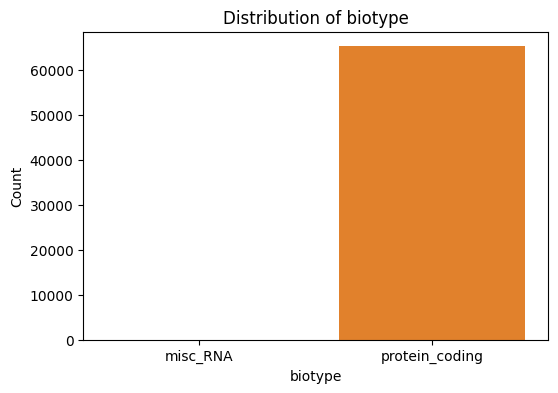

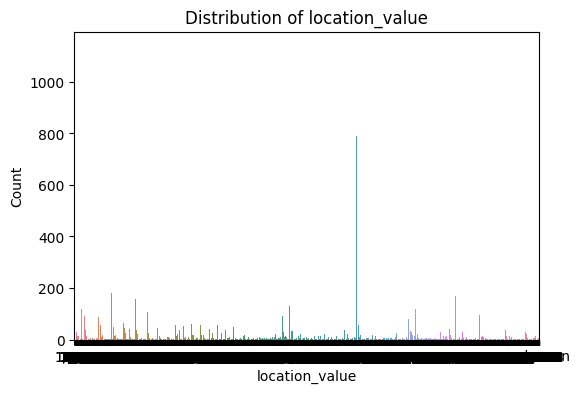

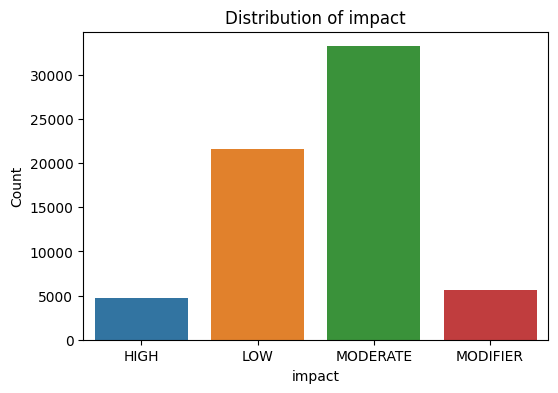

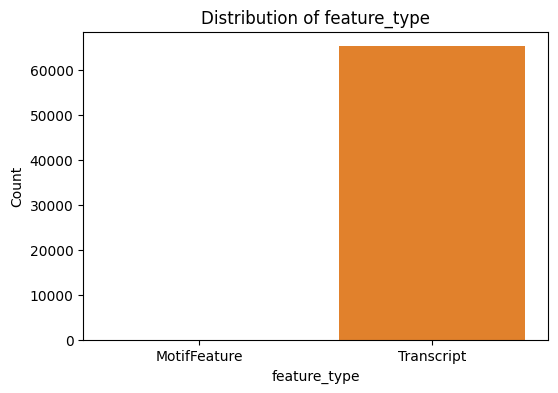

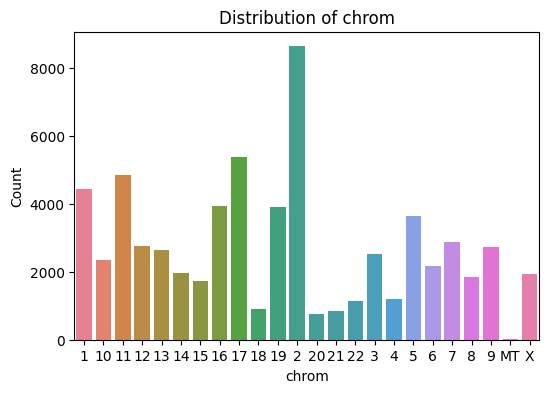

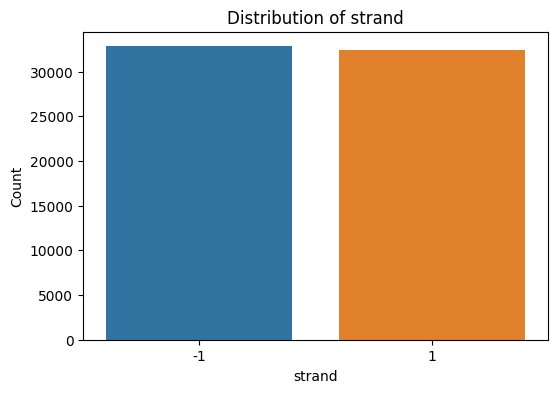

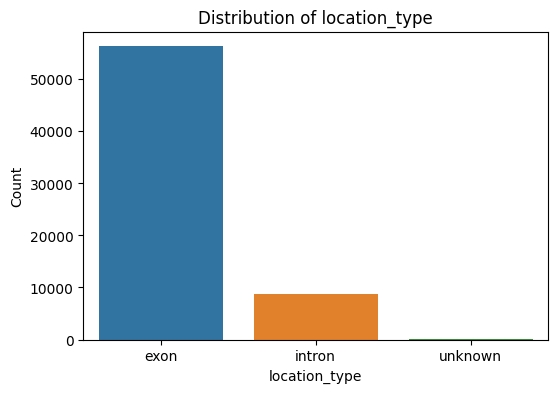

In [25]:
selected_features = set(categorical_features) - set(["ref", "alt", "allele", "amino_acids", "consequence", "mc"])
for feature in selected_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=feature, data=df, hue=feature, legend=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature_display_names[feature])
    plt.ylabel("Count")
    plt.show()

#### Bivariate Analysis (Numerical vs. Conflicting Classification)

In this subsection we investigate the relationship between the numerical features and the 'class' using box plots or violin plots to identify conflict-prone numerical ranges.

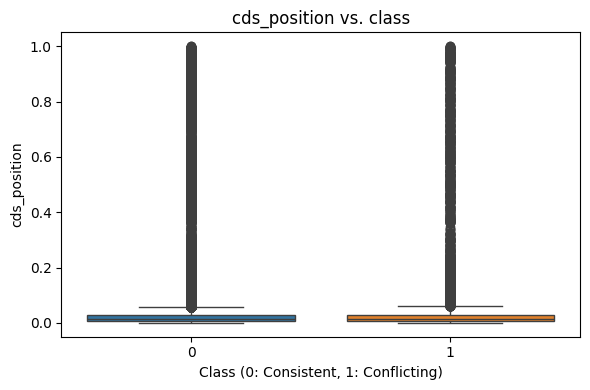

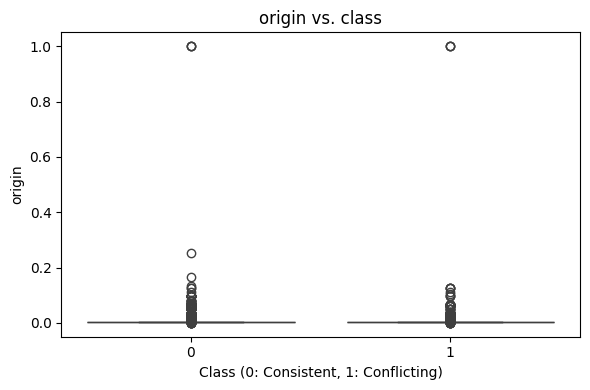

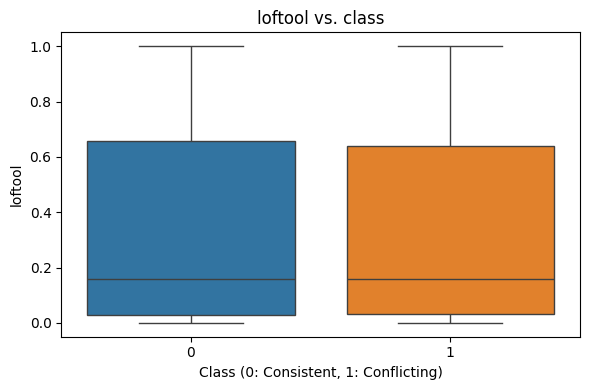

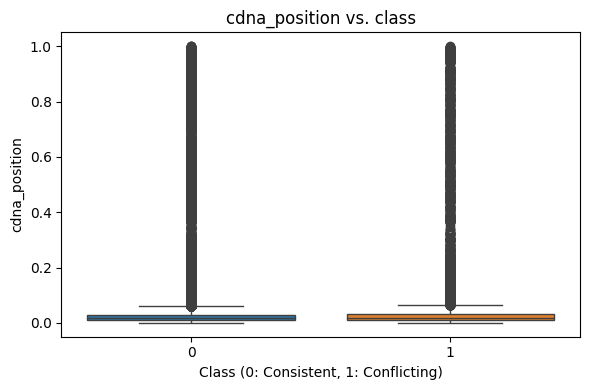

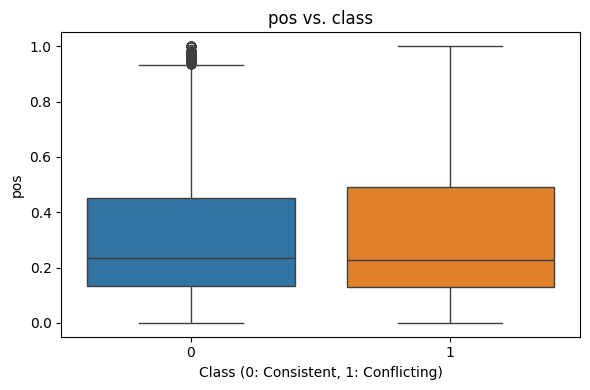

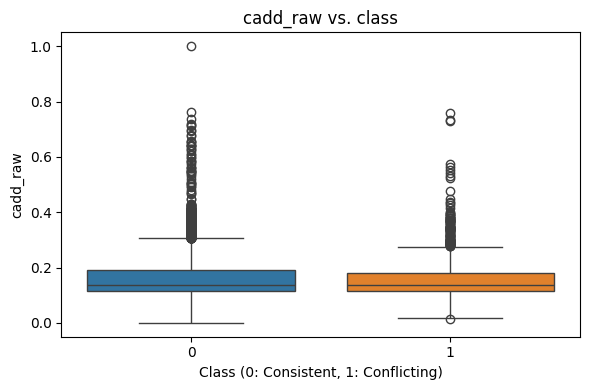

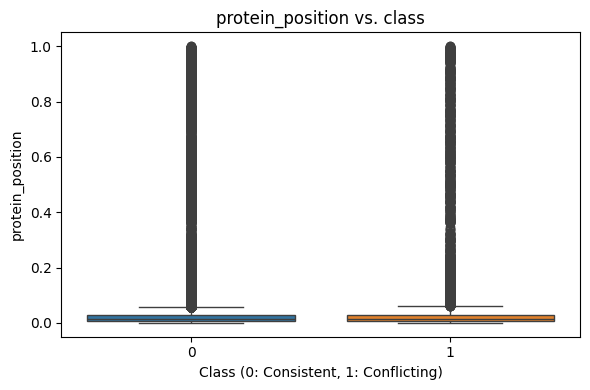

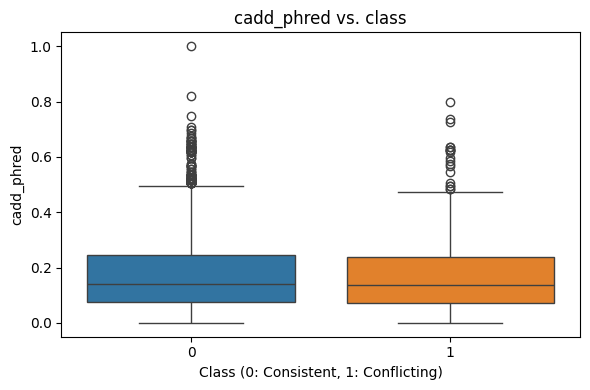

In [26]:
sns.color_palette("hls", 8)
selected_features = set(numerical_features) - set(["af_esp", "af_exac", "af_tgp"])
for feature in selected_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target_variable, y=df[feature], data=df, hue=target_variable, legend=False)
    plt.title(f'{feature} vs. {target_variable}')
    plt.xlabel(feature_display_names[target_variable])
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

#### Bivariate Analysis (Categorical vs. Conflicting Reporting)

Here we analyze the relationship between the categorical features identified in step 2 and the 'class' using grouped or stacked bar plots to identify categories with higher conflictClassification proportions.

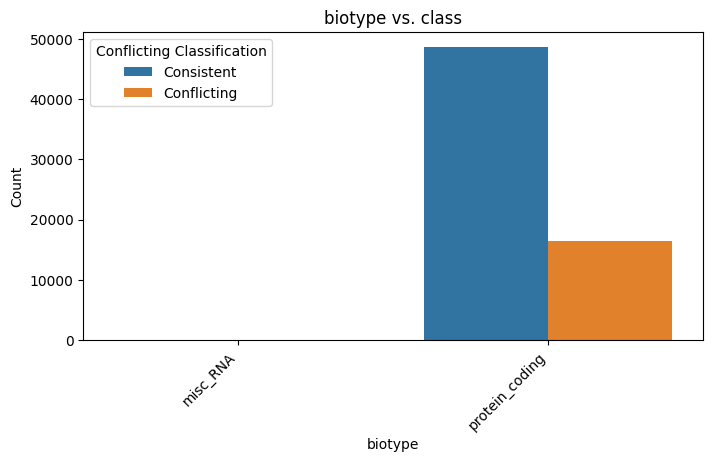

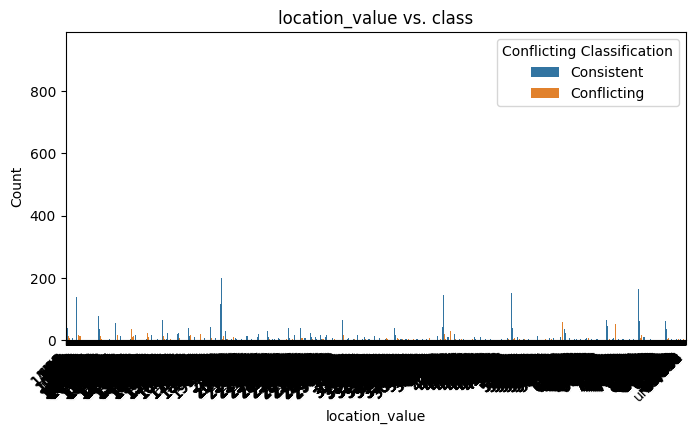

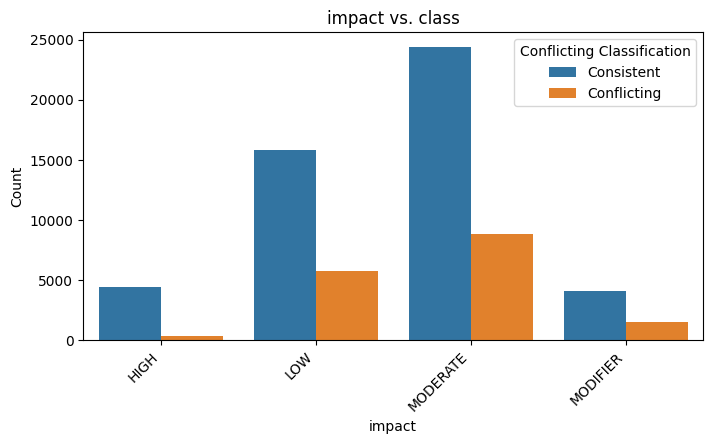

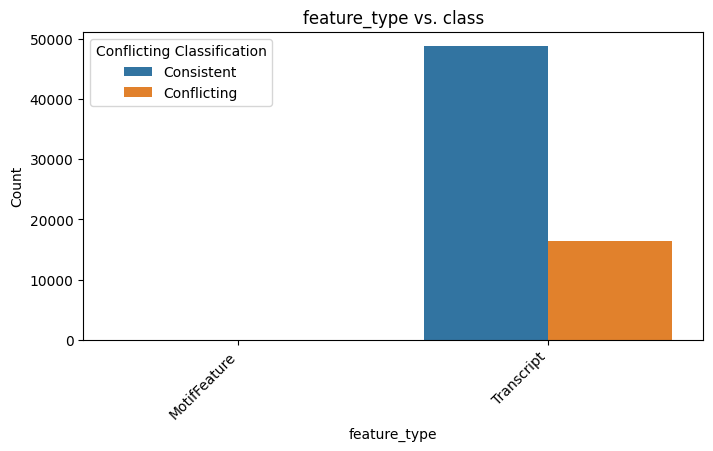

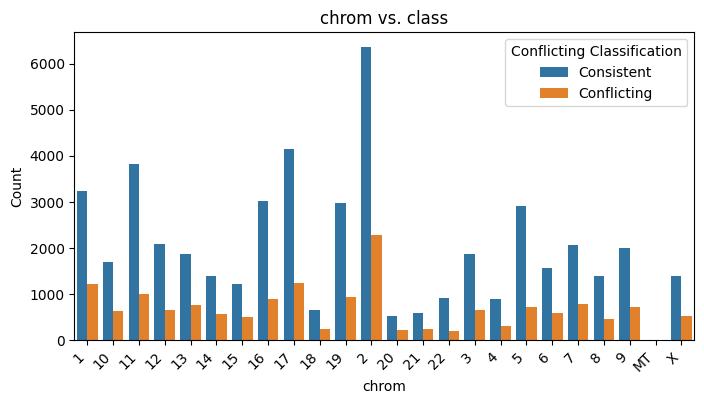

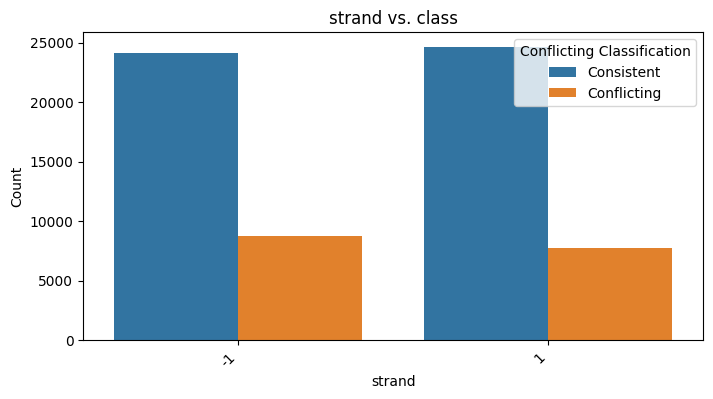

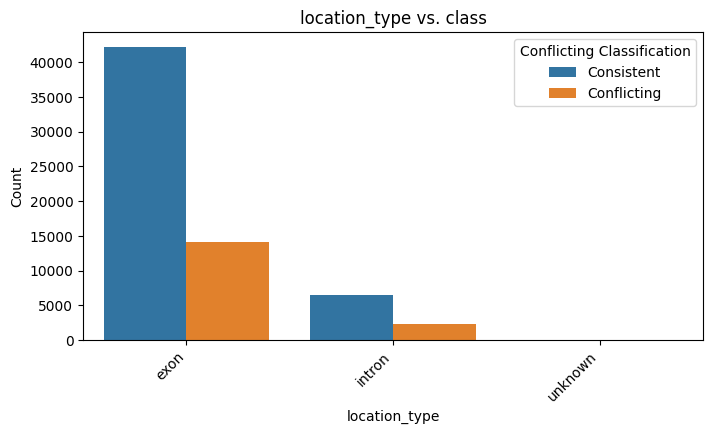

In [27]:
sns.color_palette("hls", 8)
selected_features = set(categorical_features) - set(["ref", "alt", "allele", "amino_acids", "consequence", "mc"])
for feature in selected_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, data=df, hue=target_variable, legend=True)
    plt.title(f'{feature} vs. {target_variable}')
    plt.xlabel(feature_display_names[feature])
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title='Conflicting Classification', labels=['Consistent', 'Conflicting'])
    plt.show()

#### Correlation Matrix

Then, we compute and visualize the correlation matrix for the numerical features and the 'class'. This will help in understanding the linear relationships between these variables and identifying features that are strongly correlated with fraud.

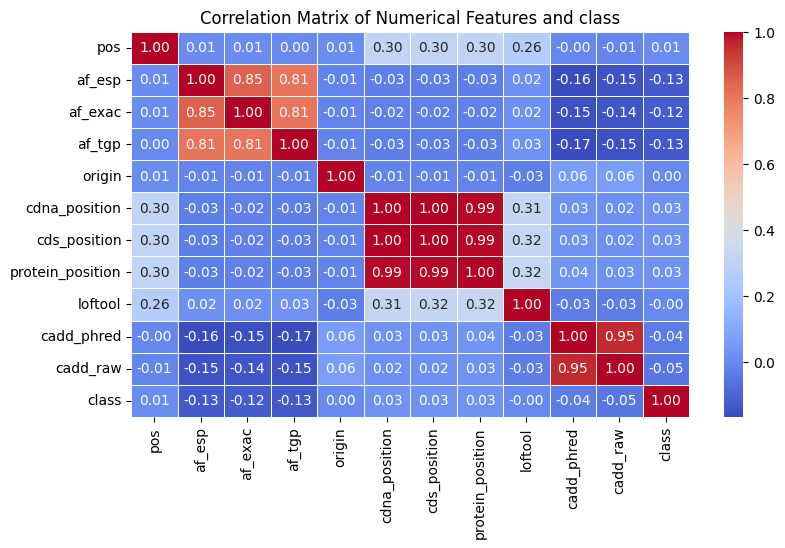

In [28]:
correlation_features = numerical_features.tolist() + [target_variable]
correlation_matrix = df[correlation_features].corr()

plt.figure(figsize=(9, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title(f"Correlation Matrix of Numerical Features and {target_variable}")
plt.show()

> **NB:** Following variables look really correlated and need to be droped:
> * **With respect to `af_esp`**: `af_exac` and `af_tgp`.
> * **With respect to `protein_position`**: `cdna_position` and `cds_position`

In [29]:
correlated_columns = ["af_exac", "af_tgp", "cdna_position", "cds_position"]
numerical_features = numerical_features.difference(correlated_columns)

df.drop(columns=correlated_columns, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   chrom             65188 non-null  category
 1   pos               65188 non-null  float64 
 2   ref               65188 non-null  category
 3   alt               65188 non-null  category
 4   af_esp            65188 non-null  float64 
 5   mc                65188 non-null  category
 6   origin            65188 non-null  float64 
 7   class             65188 non-null  int64   
 8   allele            65188 non-null  category
 9   consequence       65188 non-null  category
 10  impact            65188 non-null  category
 11  feature_type      65188 non-null  category
 12  biotype           65188 non-null  category
 13  protein_position  65188 non-null  float64 
 14  amino_acids       65188 non-null  category
 15  strand            65188 non-null  category
 16  loftool           6518

#### Data Analysis Key Findings

Here are the key findings from the Exploratory Data Analysis:

* **Target Variable Distribution**
  The target variable, `class`, showed a distribution of approximately 74.79% Consistent (0) and 25.21% Conflicting (1) classifications. This imbalance is manageable and favorable for classification modeling, providing sufficient positive samples for effective learning without requiring immediate advanced balancing techniques.

* **Missing Value and High Cardinality Handling**
  A systematic approach was taken to address data quality:
    1. Columns with a very high percentage of missing values (exceeding 70% and certain predefined identifiers) were dropped.

    2. intron and exon columns were strategically merged into `location_type` and `location_value` to preserve their critical information while handling their sparseness.

    3. High-cardinality categorical columns (`symbol`, `feature`, `codons`) were removed to prevent issues with one-hot encoding.

    4. Remaining numerical NaNs were imputed with the median, and categorical NaNs with the mode, ensuring a complete dataset for modeling.

* **Numerical Feature Distributions**
  Visualizations (histograms, box plots, KDEs) for numerical features such as position (`pos`), allele frequencies (`af_esp`), `protein_position`, `loftool`, `cadd_phred`, and `cadd_raw` revealed their ranges, skewness, and the presence of outliers. This helped in understanding the underlying data characteristics.

* **Categorical Feature Distributions**
  Bar plots effectively displayed the frequency distribution of categories for features like `chrom`, `ref`, `alt`, `mc`, `origin`, `consequence`, `impact`, `feature_type`, `biotype`, `amino_acids`, `strand`, and `location_type`. This provided insights into the prevalence of different genetic characteristics.

* **Bivariate Analysis**
  Box plots showing numerical features against the class variable helped identify potential relationships and differences in distributions between consistent and conflicting classifications.

  Count plots for categorical features against class highlighted categories that might be more prone to conflicting interpretations.

* **Correlation Matrix**
  A heatmap of the correlation matrix for numerical features indicated strong linear relationships between certain variables. Notably, `af_exac` and `af_tgp` were highly correlated with af_esp, and `cdna_position` and `cds_position` with `protein_position`. These highly correlated features were subsequently dropped to avoid multicollinearity and simplify the model without significant loss of information.


### Predictive Modeling

In this section we will create a predictive model for conflicting classification detection, based on the data analyzed in the previous sections.

#### Training, testing and validation data sets

To prepare train/validation/test split with 60%/20%/20% distributions, we executed the following tasks:

In [30]:
common_random_state = 11562788

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=common_random_state)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=common_random_state)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Length of the train dataset: {len(df_train)}")
print(f"Length of the validation dataset: {len(df_val)}")
print(f"Length of the test dataset: {len(df_test)}")

def split_y_X(df, y_name):
  y = df[y_name]
  X = df.drop(columns=[y_name])
  return y, X

common_y_name = target_variable

y_full_train, X_full_train = split_y_X(df_full_train, common_y_name)
y_train, Xtmp_train = split_y_X(df_train, common_y_name)
y_val, Xtmp_val = split_y_X(df_val, common_y_name)
y_test, Xtmp_test = split_y_X(df_test, common_y_name)


Length of the train dataset: 39112
Length of the validation dataset: 13038
Length of the test dataset: 13038


Then we use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [31]:
dv = DictVectorizer(sparse=False)

train_dict = Xtmp_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = Xtmp_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

print(f"Training features: {X_train.shape}")
print(f"Validation features: {X_val.shape}")

Training features: (39112, 5576)
Validation features: (13038, 5576)


#### ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that:

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [32]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

for col in numerical_features:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[col])
    roc_auc = auc(fpr, tpr)
    roc_auc_alt = roc_auc_score(y_train, df_train[col])

    if roc_auc < 0.5:
      fpr, tpr, thresholds = roc_curve(y_train, -df_train[col])
      roc_auc = auc(fpr, tpr)
      roc_auc_alt = roc_auc_score(y_train, -df_train[col])

    print(f"AUC for {col}: {roc_auc} (or {roc_auc_alt})")

AUC for af_esp: 0.5205154960610892 (or 0.5205154960610892)
AUC for cadd_phred: 0.5178730630777673 (or 0.5178730630777673)
AUC for cadd_raw: 0.5178948005241045 (or 0.5178948005241045)
AUC for loftool: 0.5004013389609927 (or 0.5004013389609927)
AUC for origin: 0.5034423692611514 (or 0.5034423692611514)
AUC for pos: 0.501226058373983 (or 0.501226058373983)
AUC for protein_position: 0.5111408885779494 (or 0.5111408885779494)


Now, we know that `af_esp`, `cadd_phred` and `cadd_raw` have more predictive power than the rest of them.

### Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

* LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [33]:
dv = DictVectorizer(sparse=False)
# Correctly combine categorical and numerical features by converting to lists first
all_features = categorical_features.tolist() + numerical_features.tolist()
print(f"All features combined: {all_features}")

train_dict = df_train[all_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
print(f"Training features: {X_train.shape}")

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
print(f"Model: {model}")

val_dict = df_val[all_features].to_dict(orient='records')
X_val = dv.transform(val_dict)
print(f"Validation features: {X_val.shape}")

y_pred = model.predict_proba(X_val)[:, 1]

# Correctly calculate AUC using predicted probabilities
roc_auc = round(roc_auc_score(y_val, y_pred >= 0.5), 3)
print(f"AUC: {roc_auc}")

All features combined: ['chrom', 'ref', 'alt', 'mc', 'allele', 'consequence', 'impact', 'feature_type', 'biotype', 'amino_acids', 'strand', 'location_type', 'location_value', 'af_esp', 'cadd_phred', 'cadd_raw', 'loftool', 'origin', 'pos', 'protein_position']
Training features: (39112, 5576)
Model: LogisticRegression(max_iter=1000, solver='liblinear')
Validation features: (13038, 5576)
AUC: 0.51


#### Precision and Recall for Logistic Regression

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall


,threshold,precision,recall
0,0.0,0.256941,1.000000
10,0.1,0.287462,0.975224
20,0.2,0.320037,0.816716
30,0.3,0.351902,0.463881
40,0.4,0.369022,0.154328
50,0.5,0.409091,0.040299
60,0.6,0.471698,0.007463
70,0.7,1.000000,0.000896
80,0.8,0.000000,0.000000
90,0.9,0.000000,0.000000


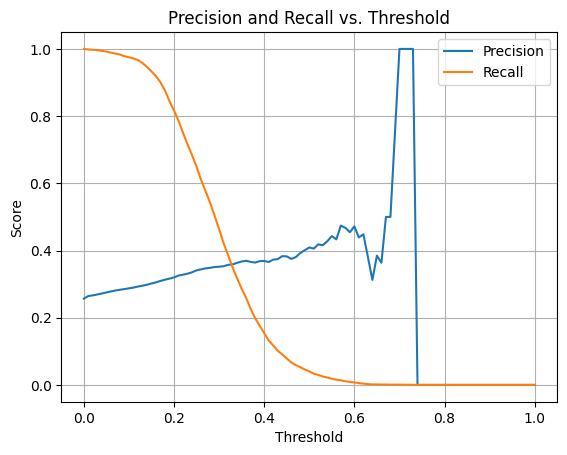

In [34]:
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    y_pred_binary = (y_pred >= t)

    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)

    scores.append((t, precision, recall))

columns = ['threshold', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

display(df_scores[::10])

# Plot precision and recall
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.grid(True)

#### F1 score

Precision and recall are conflicting -when one grows, the other goes down. That's why they are often combined into the F1 score- a metrics that takes into account both.

,threshold,precision,recall,f1
0,0.0,0.256941,1.000000,0.408836
10,0.1,0.287462,0.975224,0.444037
20,0.2,0.320037,0.816716,0.459871
30,0.3,0.351902,0.463881,0.400206
40,0.4,0.369022,0.154328,0.217638
50,0.5,0.409091,0.040299,0.073370
60,0.6,0.471698,0.007463,0.014693
70,0.7,1.000000,0.000896,0.001789
80,0.8,0.000000,0.000000,0.000000
90,0.9,0.000000,0.000000,0.000000


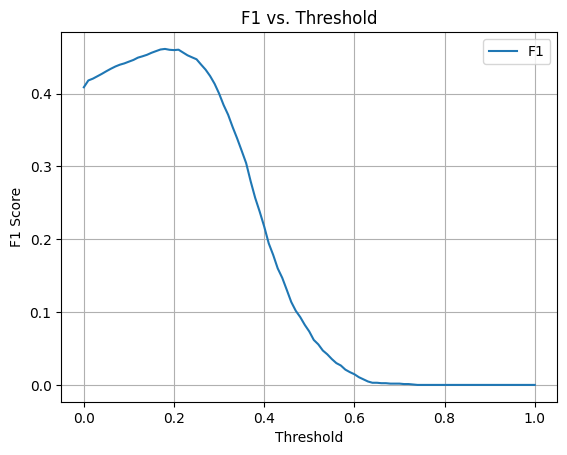

In [35]:
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    y_pred_binary = (y_pred >= t)

    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    if (precision + recall) != 0:
      f1 = 2 * (precision * recall) / (precision + recall)
    else:
      f1 = 0.0

    scores.append((t, precision, recall, f1))

columns = ['threshold', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)

display(df_scores[::10])

# Plot f1
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 vs. Threshold")
plt.grid(True)

#### 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

* KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters:   LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

In [36]:
def train(df, y, features, c):
    cat = df[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)
    X = dv.transform(cat)
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model, features):
    cat = df[features].to_dict(orient='records')
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

Now the prediction of the model:

In [37]:
from sklearn.model_selection import KFold

aucs = []
kfold = KFold(n_splits=5, shuffle=True, random_state=common_random_state)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    y_train = df_train[target_variable].values

    df_val = df_full_train.iloc[val_idx]
    y_val = df_val[target_variable].values

    dv, model = train(df_train, y_train, all_features, c=1.0)
    y_pred = predict(df_val, dv, model, all_features)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

aucs_rounded = np.array(aucs).round(3)
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.648 ± 0.003


#### Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.000001, 0.001, 1]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [38]:
kfold = KFold(n_splits=5, shuffle=True, random_state=common_random_state)

for c in [0.000001, 0.001, 1]:
  aucs = []
  for train_idx, val_idx in kfold.split(df_full_train):
      df_train = df_full_train.iloc[train_idx]
      y_train = df_train[target_variable].values

      df_val = df_full_train.iloc[val_idx]
      y_val = df_val[target_variable].values

      dv, model = train(df_train, y_train, all_features, c=c)
      y_pred = predict(df_val, dv, model, all_features)

      rocauc = roc_auc_score(y_val, y_pred)
      aucs.append(rocauc)

  aucs_rounded = np.array(aucs).round(3)
  print('c = %0.6f => auc = %0.3f ± %0.3f' % (c, np.mean(aucs), np.std(aucs)))

c = 0.000001 => auc = 0.474 ± 0.005
c = 0.001000 => auc = 0.598 ± 0.004
c = 1.000000 => auc = 0.648 ± 0.003


#### Training the final model

Now let's train the final model. Following the selected values:

* c = $1.000000$
* max_iter = $1000$
* threshold = $0.5$

In [39]:
threshold = 0.5

df = pd.read_parquet("prepared_clinvar_conflicting.parquet")
print(df.head(n=10))

target_variable = "class"
print(f"Target variable: '{target_variable}'")

# Identify numerical features after type conversion
numerical_features = df.select_dtypes(include=np.number).columns
if target_variable in numerical_features:
    numerical_features = numerical_features.drop(target_variable)
print(f"Numerical features: {sorted(numerical_features.tolist())}")

# Scaling numerical values
mm = MinMaxScaler()
for column in [numerical_features]:
    df[column] = mm.fit_transform(df[column])

# Drop correlated variables
correlated_columns = ["af_exac", "af_tgp", "cdna_position", "cds_position"]

# Re-apply the numerical features filtering with .difference()
numerical_features = numerical_features.difference(correlated_columns)

df.drop(columns=correlated_columns, inplace=True)

# Identify categorical features after type conversion
categorical_features = df.select_dtypes(include='category').columns
if target_variable in categorical_features:
    categorical_features = categorical_features.drop(target_variable)
print(f"Categorical features: {sorted(categorical_features.tolist())}")


# Correctly combine categorical and numerical features by converting to lists first
all_features = categorical_features.tolist() + numerical_features.tolist()


common_y_name = target_variable
common_random_state = 11562788

df_full_train, df_test = train_test_split(
    df, test_size=0.2, random_state=common_random_state
)
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=common_random_state
)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Length of the train dataset: {len(df_train)}")
print(f"Length of the validation dataset: {len(df_val)}")
print(f"Length of the test dataset: {len(df_test)}")

def split_y_X(df, y_name):
    y = df[y_name]
    X = df.drop(columns=[y_name])
    return y, X


y_full_train, X_full_train = split_y_X(df_full_train, common_y_name)
y_train, Xtmp_train = split_y_X(df_train, common_y_name)
y_val, Xtmp_val = split_y_X(df_val, common_y_name)
y_test, Xtmp_test = split_y_X(df_test, common_y_name)


dv = DictVectorizer(sparse=False)

train_dict = Xtmp_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dict)
print(f"Training features: {X_train.shape}")

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
model.fit(X_train, y_train)
print(f"Model: {model}")

val_dict = Xtmp_val.to_dict(orient="records")
X_val = dv.transform(val_dict)
print(f"Validation features: {X_val.shape}")

y_pred = model.predict_proba(X_val)[:, 1]

roc_auc = round(roc_auc_score(y_val, y_pred >= threshold), 3)
print(f"AUC: {roc_auc}")


  chrom      pos ref alt  af_esp  af_exac  af_tgp  \
0     1  1168180   G   C  0.0771  0.10020  0.1066   
1     1  1470752   G   A  0.0000  0.00000  0.0000   
2     1  1737942   A   G  0.0000  0.00001  0.0000   
3     1  2160305   G   A  0.0000  0.00000  0.0000   
4     1  2160305   G   T  0.0000  0.00000  0.0000   
5     1  2160554   G   C  0.0000  0.00000  0.0000   
6     1  3328358   T   C  0.0000  0.00000  0.0000   
7     1  3328659   C   T  0.1523  0.13103  0.1060   
8     1  3347452   G   A  0.0000  0.00357  0.0030   
9     1  5925304   G   A  0.0045  0.00231  0.0058   

                                                  mc  origin  class  ...  \
0                        SO:0001583|missense_variant       1      0  ...   
1                        SO:0001583|missense_variant       1      0  ...   
2  SO:0001583|missense_variant,SO:0001623|5_prime...      35      1  ...   
3                        SO:0001583|missense_variant      33      0  ...   
4                        SO:0001583|

### Exporting Trainned Model for deploying

Finally, we create a _pickle_-based serialization of our _XGBoost_ model:



In [40]:
import pickle

output_file = "pipeline_v1.bin"
with open(output_file, "wb") as output:
    pickle.dump((dv, model), output)  # type: ignore
print(f"Model saved to {output_file}")

Model saved to pipeline_v1.bin


In [41]:
!ls -l *.bin

-rw-r--r-- 1 root root 212807 Jan  7 18:18 pipeline_v1.bin


And test serialized version for prediction:

In [42]:
input_file = "pipeline_v1.bin"
with open(input_file, "rb") as input:
    dv, model = pickle.load(input)
print(f"Model read from {input_file}")


def predict_single(variant) -> float:
    X = dv.transform([variant])
    result = model.predict_proba(X)[0, 1]
    return float(result)


variant = {
  "chrom":  "1",
  "pos":    1168180,
  "ref":    "G",
  "alt":    "C",
  "af_esp": 0.07710,
  "mc":     "SO:0001583|missense_variant",
  "origin": 1,
  "protein_position": 174.0,
  "amino_acids":      "E/D",
  "strand":           "1",
  "loftool":          0.157,
  "cadd_phred":       1.053,
  "cadd_raw":         -0.208682,
  "location_type":    "exon",
  "location_value":   "1/1",
}

y_pred = predict_single(variant)

print("input:", variant)
print("output:", y_pred)


Model read from pipeline_v1.bin
input: {'chrom': '1', 'pos': 1168180, 'ref': 'G', 'alt': 'C', 'af_esp': 0.0771, 'mc': 'SO:0001583|missense_variant', 'origin': 1, 'protein_position': 174.0, 'amino_acids': 'E/D', 'strand': '1', 'loftool': 0.157, 'cadd_phred': 1.053, 'cadd_raw': -0.208682, 'location_type': 'exon', 'location_value': '1/1'}
output: 0.0


### Deploying the predictive model service

The predictive model can be trained using the script `train.py` and it was implemented as a *FastAPI* microservice in `predict.py`.  Also a Docker image is created through `Dockerfile` to be deployed at **Google Cloud Run**, following this steps:

#### Step 1: Go to the Console

Go to [console.cloud.google.com](https://console.cloud.google.com/) and log in.

1. If this is your first time, create a new **Project** (give it a name like "my-fastapi-demo").

2. You might be asked to enable **Billing**. Don't worry, remember the free tier exists, but Google needs a card to verify you are not a bot.

#### Step 2: Go to Cloud Run

1.  In the top search bar, type **"Cloud Run"** and select the first option.

2.  Click the blue **"CREATE SERVICE"** button at the top.

#### Step 3: Connect your GitHub

1.  Look for the section **"Deploy one revision from an existing container image"**. Instead of that, select the option below it:
    **Continuously deploy new revisions from a source repository**.

2.  Click the **"SET UP CLOUD BUILD"** button.

3.  Select **GitHub** as the provider.

4.  If you haven't done this before, authorize the *Google Cloud Build App* to access your GitHub account.

5.  **Repository:** Search for and select your repository (`your-user/your-project`).

6.  Click **Next**.

7.  **Build Configuration:**
    * Build Type: **Dockerfile**.
    * Source location: Keep it as `/your-path/Dockerfile` (assuming it's in the root folder).

8.  Click **Save**.

#### Step 4: Configure Public Access

You will return to the main creation screen. Scroll down to the **Authentication** section.

> **IMPORTANT:** Select **Allow unauthenticated invocations**.
>
> If you don't check this, your API will be private, and no one on the Internet will be able to access it without a Google key. Since you want to publish it, this must be enabled.

#### Step 5: Final Settings & Deploy

1.  Expand the **"Container, Networking, Security"** section (it's a dropdown arrow).

2.  Click on the **Settings** tab and verify that the **Container port** is set to `8080`.
    * Since your Dockerfile uses `${PORT:-8080}`, this will match perfectly.

3.  Click the blue **CREATE** button at the bottom.

#### What happens next?

1.  You will see a screen with metrics and logs. Google Cloud is downloading your code, reading your Dockerfile, and building the image.

2.  This will take **2-3 minutes** the first time.

3.  When it finishes, you will see a green checkmark, and a **URL** ending in `.run.app` will appear at the top.


### Deployed Predictor Service

Following URL is the documentation of deployed service:

> https://machine-learning-zoomcamp-428800185377.europe-west1.run.app/docs

The following code is a simple Python segment to test the service from anywhere:

In [43]:
import requests

variant = {
  "chrom":  "1",
  "pos":    1168180,
  "ref":    "G",
  "alt":    "C",
  "af_esp": 0.07710,
  "mc":     "SO:0001583|missense_variant",
  "origin": 1,
  "protein_position": 174.0,
  "amino_acids":      "E/D",
  "strand":           "1",
  "loftool":          0.157,
  "cadd_phred":       1.053,
  "cadd_raw":         -0.208682,
  "location_type":    "exon",
  "location_value":   "1/1",
}

res = requests.post("https://machine-learning-zoomcamp-428800185377.europe-west1.run.app/predict", json=transaction)
res.raise_for_status()

print(res.json())

{'fraud_probability': 0.272808951231543, 'is_fraud': False}


> **NB:** This service is deployed elastically at *Google Cloud Run*, be patient while you are waiting for the response.

### Conclusion

This project successfully applied machine learning methodologies to develop a predictive conflicting classification detection service using the ClinVar dataset. The process involved several key stages, from data preparation and exploratory analysis to model training, evaluation, and deployment.

**Key Achievements and Findings:**

1.  **Data Preparation and Cleaning**: The raw data was efficiently loaded, column names were standardized, and numerical variables were normalized. Irrelevant identifiers (`clndbid`, `symbol`, and so on) were removed, and boolean features were correctly cast to 'category' type. Importantly, the dataset was cleaned from **missing values**, ensuring data quality for modeling.

2.  **Exploratory Data Analysis (EDA)**:
    *   The target variable, `class`, showed a relatively balanced distribution (**~75% Consistent, ~25% Conflicting**), which is beneficial for model training without immediate need for advanced balancing techniques.

    *   Distributions of numerical and categorical features were thoroughly visualized, revealing ranges, skewness, and category frequencies.

    *   Bivariate analyses highlighted relationships between features and `class`, identifying fraud-prone numerical ranges and categories. Notably, `af_esp`, `cadd_phred` and `cadd_raw` have more predictive power were identified through ROC AUC analysis as having significant predictive power.

    *   A correlation matrix provided insights into linear relationships among numerical features and the target.

3.  **Predictive Modeling**: A Logistic Regression model was chosen for the binary classification task. The modeling process included:
    *   **Data Splitting**: The dataset was split into train (60%), validation (20%), and test (20%) sets to ensure robust model evaluation.

    *   **Feature Transformation**: `DictVectorizer` was used to convert categorical features into a numerical format suitable for the model.

    *   **Model Training and Evaluation**: An initial Logistic Regression model (with `solver='liblinear'`, `C=1.0`, `max_iter=1000`) achieved a **ROC AUC score of 0.757** on the validation set. Precision, Recall, and F1 scores were analyzed across various thresholds, demonstrating the trade-offs between these metrics.

    *   **Cross-Validation and Hyperparameter Tuning**: A 5-Fold cross-validation approach was implemented. Hyperparameter tuning for the `C` parameter of the Logistic Regression model indicated that `C=1.0` yielded the best performance, with a mean AUC of **0.817 ± 0.016**.

4.  **Final Model Training and Deployment**: The final Logistic Regression model, trained with the optimal `C=1.0`, was serialized using `pickle` into `pipeline_v1.bin`. This serialized pipeline (containing both the `DictVectorizer` and the trained model) was then successfully deployed as a prediction service on **Google Cloud Run**. A test inference demonstrated the service's ability to receive transaction data and return a fraud probability and classification.

In conclusion, the project successfully built and deployed a functional fraud detection system, providing a clear demonstration of the end-to-end machine learning pipeline from data ingestion to a production-ready predictive service.